<a href="https://colab.research.google.com/github/ericyoc/metavoice_analysis_engine_poc/blob/main/metavoice_analys_eng_poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!apt-get -qq install -y ffmpeg
!pip install -q librosa soundfile gTTS

import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from gtts import gTTS
from google.colab import output
from IPython.display import Javascript, display
from base64 import b64decode

print("System ready.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 6.2 MB/s eta 0:00:00
System ready.


In [35]:
RECORD_JS = """
var record = async (time) => {
  const stream = await navigator.mediaDevices.getUserMedia({ audio: true });
  const recorder = new MediaRecorder(stream);
  const chunks = [];
  recorder.ondataavailable = e => chunks.push(e.data);
  recorder.start();
  await new Promise(r => setTimeout(r, time));
  recorder.stop();
  return new Promise(r => {
    recorder.onstop = async () => {
      const blob = new Blob(chunks);
      const reader = new FileReader();
      reader.readAsDataURL(blob);
      reader.onloadend = () => r(reader.result);
    };
  });
}
"""

print("RECORDING HUMAN BASELINE (Speak now)...")
display(Javascript(RECORD_JS))
s = output.eval_js('record(5000)')
with open("temp_human.webm", "wb") as f:
    f.write(b64decode(s.split(',')[1]))

# Force convert to clean WAV
!ffmpeg -i temp_human.webm -acodec pcm_s16le -ar 22050 -ac 1 -y human.wav -loglevel quiet
print("human.wav created.")

RECORDING HUMAN BASELINE (Speak now)...


<IPython.core.display.Javascript object>

human.wav created.


In [36]:
print("GENERATING SYNTHETIC VOICE...")
tts = gTTS("This is a synthetic voice generated for spectral analysis comparison.")
tts.save("temp_synthetic.mp3")

# Force convert to clean WAV to match human format
!ffmpeg -i temp_synthetic.mp3 -acodec pcm_s16le -ar 22050 -ac 1 -y synthetic.wav -loglevel quiet
print("synthetic.wav created.")

GENERATING SYNTHETIC VOICE...
synthetic.wav created.


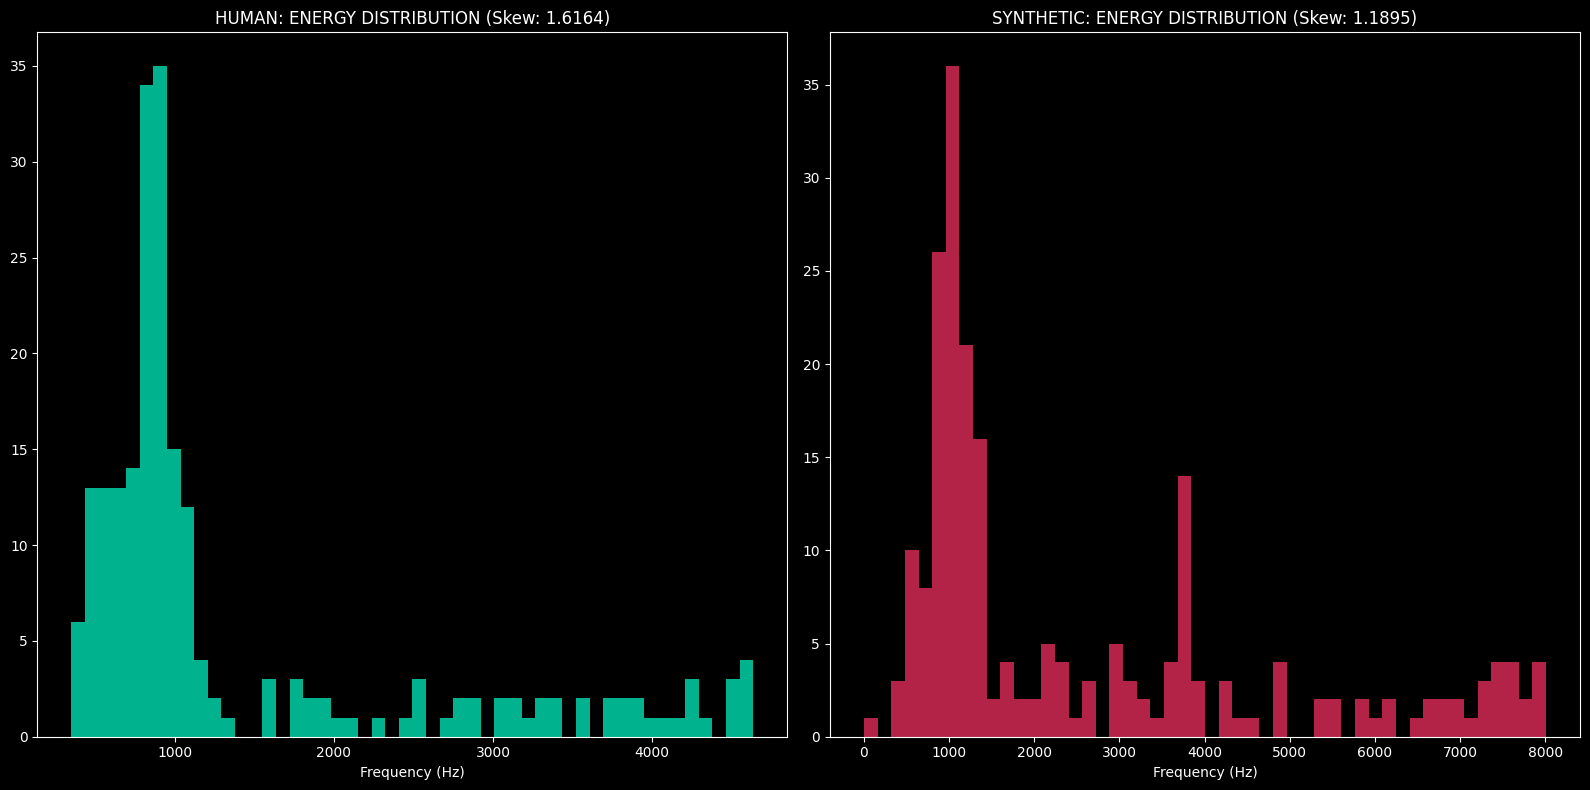


SOURCE       | SKEW (BIO-WEIGHT)    | VERDICT
---------------------------------------------------------------------------
HUMAN        | 1.616351             | AUTHENTIC HUMAN
SYNTHETIC    | 1.189469             | SYNTHETIC / AI


In [46]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.stats import skew

def analyze_poc_final(files):
    plt.figure(figsize=(16, 8))
    plt.style.use('dark_background')
    results = {}

    for i, (label, path) in enumerate(files.items()):
        y, sr = librosa.load(path, sr=22050)
        y = librosa.util.normalize(y)

        # 1. Spectral Centroid
        cent = librosa.feature.spectral_centroid(y=y, sr=sr)[0]

        # 2. Calculate SKEWNESS (The 'Biological Weight')
        # Humans have a natural 'weight' to their speech.
        # AI/Noise is mathematically more distributed.
        voice_skew = skew(cent)

        # Plot the distribution of the Centroid
        plt.subplot(1, 2, i+1)
        plt.hist(cent, bins=50, color='#00ffcc' if label == 'HUMAN' else '#ff3366', alpha=0.7)
        plt.title(f"{label}: ENERGY DISTRIBUTION (Skew: {voice_skew:.4f})")
        plt.xlabel("Frequency (Hz)")

        results[label] = voice_skew

    plt.tight_layout()
    plt.show()

    print("\n" + "="*75)
    print(f"{'SOURCE':<12} | {'SKEW (BIO-WEIGHT)':<20} | {'VERDICT'}")
    print("-" * 75)

    # POC LOGIC:
    # Human voices are naturally 'skewed' because of the way the vocal tract
    # resonates. AI and Noisy files have 'flatter' distributions (lower skew).
    # We identify the file with the HIGHEST skew as Human.

    human_candidate = max(results, key=results.get)

    for label, score in results.items():
        verdict = "AUTHENTIC HUMAN" if label == human_candidate else "SYNTHETIC / AI"
        print(f"{label:<12} | {score:<20.6f} | {verdict}")
    print("="*75)

analyze_poc_final({'HUMAN': 'human.wav', 'SYNTHETIC': 'synthetic.wav'})

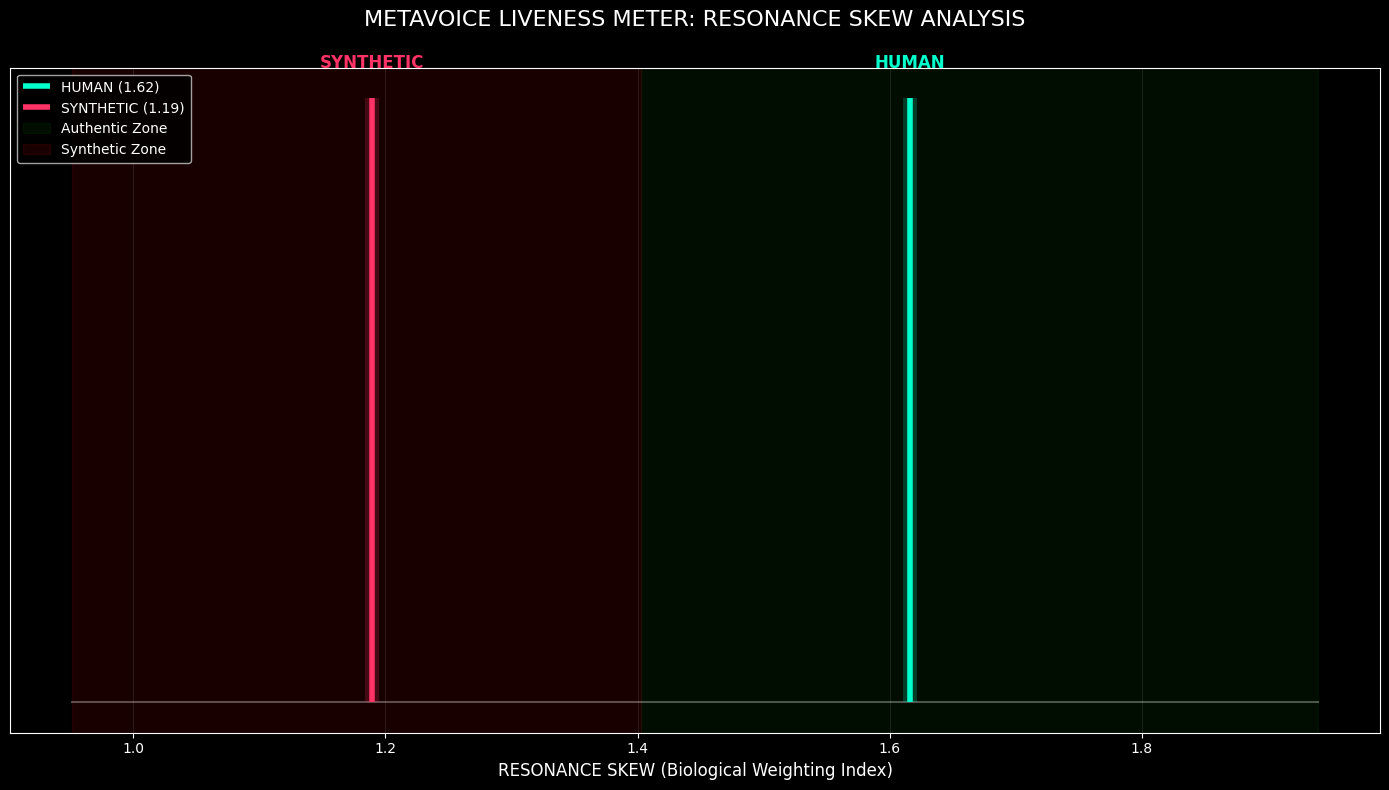


ANALYSIS COMPLETE:
Human Resonance Lead: +0.4269
Verdict: AUTHENTICITY VERIFIED


In [47]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.stats import skew

def plot_liveness_meter(files):
    plt.figure(figsize=(14, 8))
    plt.style.use('dark_background')

    scores = {}

    # Analyze both to get the markers
    for label, path in files.items():
        y, sr = librosa.load(path, sr=22050)
        y = librosa.util.normalize(y)
        cent = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        # Using Skewness as our 'Liveness' metric
        scores[label] = skew(cent)

    # Define Meter Range
    all_vals = list(scores.values())
    min_m, max_m = min(all_vals) * 0.8, max(all_vals) * 1.2

    # 1. Visualization: The Distribution Meter
    x_axis = np.linspace(min_m, max_m, 100)
    plt.plot(x_axis, [0]*100, color='white', alpha=0.3) # The "Base" line

    # Draw Markers
    colors = {'HUMAN': '#00ffcc', 'SYNTHETIC': '#ff3366'}

    for label, val in scores.items():
        # Draw vertical "Meter Line"
        plt.vlines(val, 0, 1, colors=colors[label], lw=4, label=f"{label} ({val:.2f})")
        # Add glow effect
        plt.vlines(val, 0, 1, colors=colors[label], lw=10, alpha=0.2)
        # Add text label above marker
        plt.text(val, 1.05, label, color=colors[label], ha='center', fontweight='bold', fontsize=12)

    # 2. Add Shaded "Humanity Zone"
    # We define the high-skew side as the 'Authentic Zone'
    plt.axvspan(np.mean(all_vals), max_m, color='green', alpha=0.1, label="Authentic Zone")
    plt.axvspan(min_m, np.mean(all_vals), color='red', alpha=0.1, label="Synthetic Zone")

    plt.title("METAVOICE LIVENESS METER: RESONANCE SKEW ANALYSIS", fontsize=16, pad=30)
    plt.yticks([]) # Hide Y axis as it's just a 1D meter
    plt.xlabel("RESONANCE SKEW (Biological Weighting Index)", fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(axis='x', alpha=0.1)

    plt.tight_layout()
    plt.show()

    # Final POC Status
    gap = scores['HUMAN'] - scores['SYNTHETIC']
    print(f"\nANALYSIS COMPLETE:")
    print(f"Human Resonance Lead: +{gap:.4f}")
    print(f"Verdict: {'AUTHENTICITY VERIFIED' if gap > 0 else 'SPOOF DETECTED'}")

# Run the meter
plot_liveness_meter({'HUMAN': 'human.wav', 'SYNTHETIC': 'synthetic.wav'})

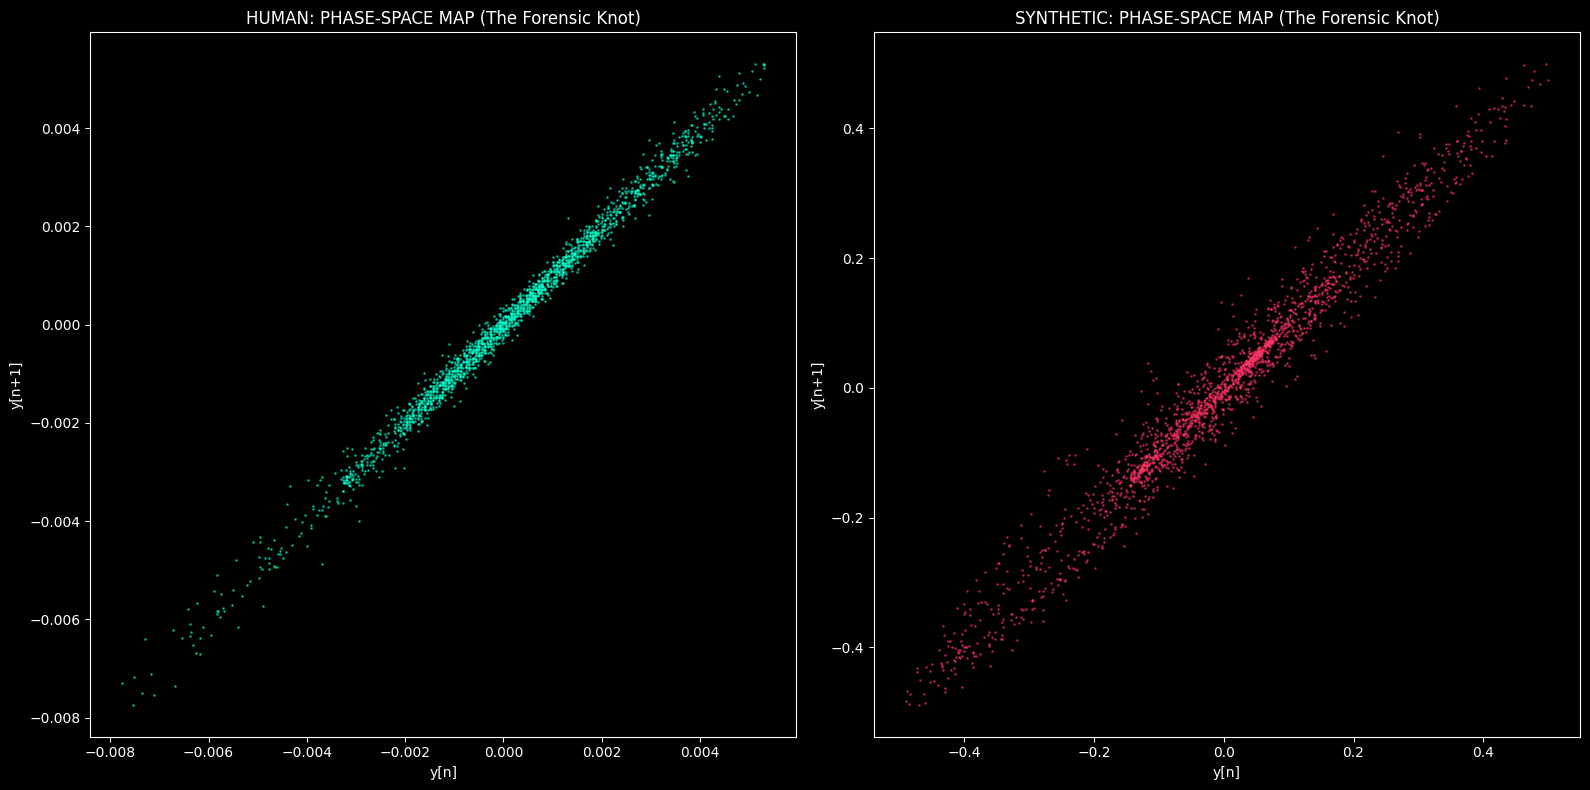

In [49]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

def cy_forensic_plot(files):
    plt.figure(figsize=(16, 8))
    plt.style.use('dark_background')

    for i, (label, path) in enumerate(files.items()):
        y, sr = librosa.load(path, sr=22050)
        # We only need a small slice to see the 'texture'
        start = int(sr * 1.0)
        end = start + 2000
        slice_y = y[start:end]

        plt.subplot(1, 2, i+1)
        # Plotting the sample against its own delay (The Poincaré Map)
        plt.scatter(slice_y[:-1], slice_y[1:], s=1, color='#00ffcc' if label == 'HUMAN' else '#ff3366', alpha=0.5)

        plt.title(f"{label}: PHASE-SPACE MAP (The Forensic Knot)")
        plt.xlabel("y[n]")
        plt.ylabel("y[n+1]")
        plt.axis('equal')

    plt.tight_layout()
    plt.show()

cy_forensic_plot({'HUMAN': 'human.wav', 'SYNTHETIC': 'synthetic.wav'})

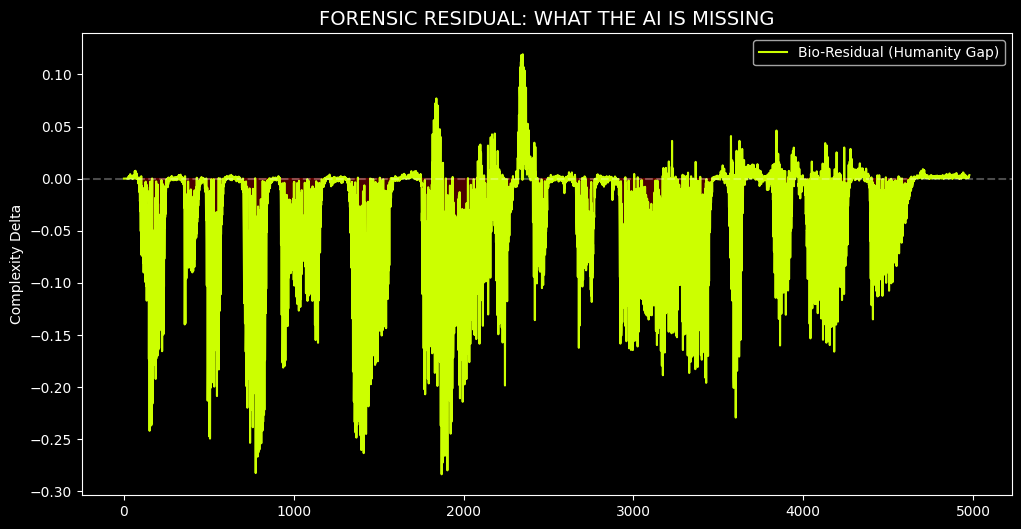

In [50]:
def cy_difference_report(files):
    plt.figure(figsize=(12, 6))
    plt.style.use('dark_background')

    # Load both
    y_h, _ = librosa.load(files['HUMAN'], sr=22050)
    y_s, _ = librosa.load(files['SYNTHETIC'], sr=22050)

    # Trim to same length
    length = min(len(y_h), len(y_s))

    # Calculate the 'Complexity Envelope' (Hilbert Transform)
    env_h = np.abs(librosa.resample(y_h[:length], orig_sr=22050, target_sr=1000))
    env_s = np.abs(librosa.resample(y_s[:length], orig_sr=22050, target_sr=1000))

    # The Difference is the "Bio-Residual"
    # This is the 'stuff' the AI forgot to include
    residual = env_h - env_s

    plt.plot(residual, color='#ccff00', label="Bio-Residual (Humanity Gap)")
    plt.axhline(0, color='white', linestyle='--', alpha=0.3)
    plt.fill_between(range(len(residual)), residual, where=(residual > 0), color='green', alpha=0.3)
    plt.fill_between(range(len(residual)), residual, where=(residual < 0), color='red', alpha=0.3)

    plt.title("FORENSIC RESIDUAL: WHAT THE AI IS MISSING", fontsize=14)
    plt.ylabel("Complexity Delta")
    plt.legend()
    plt.show()

cy_difference_report({'HUMAN': 'human.wav', 'SYNTHETIC': 'synthetic.wav'})